In [2]:
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

from keras.applications import (vgg16,  vgg19, xception, 
                                inception_v3,  inception_resnet_v2, 
                                mobilenet,densenet, nasnet, mobilenet_v2)

nb_closest_images = 5 # number of most similar images to retrieve

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
#https://www.kaggle.com/jonathanoheix/product-recommendation-based-on-visual-similarity
import os
"""os.chdir'/home/jupyter/train/')
files = ['D:/Documents/MangAI/src/Dataset/pictures/' + x for x in os.listdir() if x.endswith('jpg')]
files[:10]"""

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

"os.chdir'/home/jupyter/train/')\nfiles = ['D:/Documents/MangAI/src/Dataset/pictures/' + x for x in os.listdir() if x.endswith('jpg')]\nfiles[:10]"

In [3]:
manga = pd.read_csv('/home/jupyter/MangaInfo (1).csv')
manga.head()

,title,genre,poster,staff,score,synopsis,popularity
0,Z,"Action , Comedy , Mystery , Drama , Shoujo , H...",https://cdn.myanimelist.net/images/manga/2/457...,Aoike Yasuko,7.03,"The adventures of Agent Z, the newest recruit ...",24669
1,y,"Hentai , School , Doujinshi",https://cdn.myanimelist.net/images/manga/2/153...,Kishi Kaisei,6.24,1. y[16:21-20:47] Imakara Atashi Okasaremasu.,25046
2,Zion_no_Koeda,"Drama , Historical , Yaoi , Magazine Be x Boy",https://cdn.myanimelist.net/images/manga/3/251...,Inariya Fusanosuke,7.04,A former Nazi official is kept captive by the ...,4242
3,Yuuwaku_no_Bansan,"Romance , Josei",https://cdn.myanimelist.net/images/manga/2/116...,Katsumoto Kasane,6.70,From StarryHeaven:,4916
4,Yume_no_Akichi,"Dementia , Drama , Fantasy , Supernatural , Ps...",https://cdn.myanimelist.net/images/manga/3/137...,Oda Hideji,7.02,Renei thinks she's going crazy. After many yea...,14175


In [4]:
manga["title"] = manga["title"].replace({"%" : ""}, regex=True)
manga= manga[(manga["title"] != "") & (manga["title"].notnull())]

In [ ]:
import requests
from tqdm import tqdm 

for url, title in zip(manga["poster"], manga["title"]) : 
    with open('Untitled Folder/{}.jpg'.format(title), 'wb') as f:
        f.write(requests.get(url).content)

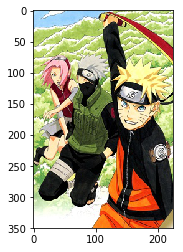

image loaded successfully!


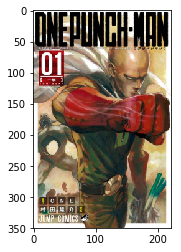

image loaded successfully!


In [4]:
from urllib.request import urlopen
from PIL import Image

naruto_poster = manga.query("title == 'Naruto'")["poster"].iloc[0]
one_punch_poster = manga.query("title == 'One_Punch-Man'")["poster"].iloc[0]
#berserk_poster = manga.query("title == 'Berserk'")["poster"].iloc[0]

for poster in [naruto_poster, one_punch_poster] :
    img = Image.open(urlopen(poster))
    plt.imshow(img)
    plt.show()
    print("image loaded successfully!")

In [6]:


class ImageRecommender : 
    
    def __init__(self, model, list_of_image, filespath) : 
        self.model = model
        self.filespath = filespath
        self.list_of_image = list_of_image
        #since ouput.shape return object dimension just eval it to get integer ...
        self.image_width = eval(str(self.model.layers[0].output.shape[1]))
        self.image_height = eval(str(self.model.layers[0].output.shape[2]))
        # remove the last layers in order to get features instead of predictions
        self.image_features_extractor = Model(inputs=self.model.input, 
                                              outputs=self.model.layers[-2].output)
        self.processed_image = self.Pics2Matrix()
        self.sim_table = self.GetSimilarity(self.processed_image)
        
    def ddl_images(self, image_url) :
        try : 
            return load_img(self.filespath + image_url, 
                            target_size=(self.image_width, self.image_height))
        except OSError : 
            # image unreadable // remove from list
            self.list_of_image = [x for x in self.list_of_image if x != image_url]
            #self.list_of_image.remove(image_url)
            pass
        
    def Pics2Matrix(self) :
        """
        # convert the PIL image to a numpy array
        # in PIL - image is in (width, height, channel)
        # in Numpy - image is in (height, width, channel)
        # convert the image / images into batch format
        # expand_dims will add an extra dimension to the data at a particular axis
        # we want the input matrix to the network to be of the form (batchsize, height, width, channels)
        # thus we add the extra dimension to the axis 0.
        """
        #from keras.preprocessing.image import load_img,img_to_array
        list_of_expanded_array = list()
        for i in tqdm(range(len(self.list_of_image) - 1)) :
            try :
                tmp = img_to_array(self.ddl_images(self.list_of_image[i]))
                expand = np.expand_dims(tmp, axis = 0)
                list_of_expanded_array.append(expand)
            except ValueError : 
                self.list_of_image = [x for x in self.list_of_image if x != self.list_of_image[i]]
                #self.list_of_image.remove(self.list_of_image[i])
        images = np.vstack(list_of_expanded_array)
        """
        list_of_expanded_array = [try np.expand_dims(img_to_array(self.ddl_images(self.list_of_image[i])), axis = 0) except ValueError pass \
                                  for i in tqdm(range(len(self.list_of_image)))]
        images = np.vstack(list_of_expanded_array)
        #from keras.applications.imagenet_utils import preprocess_input()
        # prepare the image for the  model"
        """
        return preprocess_input(images)
    
    def GetSimilarity(self, processed_imgs) :
        print('============ algorithm predict featurs =========')
        imgs_features = self.image_features_extractor.predict(processed_imgs)
        print("Our image has %i features:" %imgs_features.size)
        cosSimilarities = cosine_similarity(imgs_features)
        cos_similarities_df = pd.DataFrame(cosSimilarities, 
                                           columns=self.list_of_image[:len(self.list_of_image) -1],
                                           index=self.list_of_image[:len(self.list_of_image) -1])
        return cos_similarities_df
    
    def most_similar_to(self, given_img, nb_closest_images = 5):

        print("-----------------------------------------------------------------------")
        print("original manga:")

        original = self.ddl_images(given_img)
        plt.imshow(original)
        plt.show()

        print("-----------------------------------------------------------------------")
        print("most similar manga:")

        closest_imgs = self.sim_table[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
        closest_imgs_scores = self.sim_table[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

        for i in range(0,len(closest_imgs)):
            original = self.ddl_images(closest_imgs[i])
            plt.imshow(original)
            plt.show()
            print("similarity score : ",closest_imgs_scores[i])

In [7]:
vgg_model = vgg16.VGG16(weights='imagenet')

mobv2= mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, 
                                       include_top=True, 
                                       weights='imagenet')

nasnetmobile = nasnet.NASNetMobile(weights="imagenet")

mobilenet_ = mobilenet.MobileNet(weights="imagenet")

incepv2 = inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', 
                                                input_tensor=None, input_shape=None, pooling=None, classes=1000)

incepv3 = inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, 
                                   input_shape=None, pooling=None, classes=1000)

Xception_ = xception.Xception(include_top=True, weights='imagenet', input_tensor=None, 
                              input_shape=None, pooling=None, classes=1000)


W0930 20:27:55.919243 139689424054016 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0930 20:27:56.183234 139689424054016 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0930 20:27:56.305366 139689424054016 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0930 20:27:56.460087 139689424054016 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0930 20:28:01.664940 139689424054016 deprecation_wrapp

In [8]:
files = [x for x in os.listdir('Untitled Folder/') if x.endswith('jpg')]
files[:5]

['Ore_wa_Mada_Honki_Dashitenai_dake.jpg',
 'No_no_Kagi.jpg',
 'Nyuukan_Squeeze.jpg',
 'Konna_ni_Yasashiku_Sareta_no.jpg',
 'Gekkou_no_Carnevale__Hakugin_no_Caryatid.jpg']


  0%|          | 48/26109 [00:00<00:54, 476.18it/s]

 /t pretrained model <keras.engine.training.Model object at 0x7f8fd2f8cf98> are running



100%|██████████| 26109/26109 [00:58<00:00, 445.65it/s]

============ algorithm predict featurs =========
Our image has 106942464 features:
Most similar to Naruto
-----------------------------------------------------------------------
original manga:


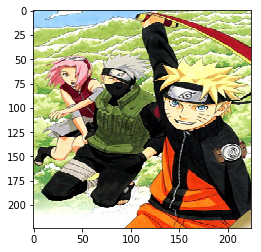

-----------------------------------------------------------------------
most similar manga:


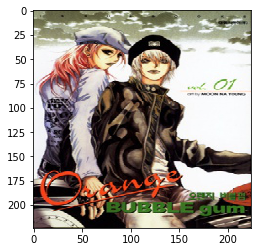

similarity score :  0.54793847


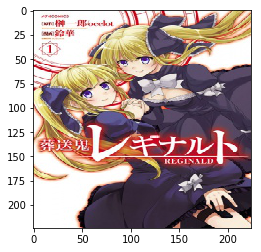

similarity score :  0.54007876


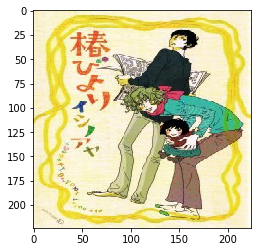

similarity score :  0.5379782


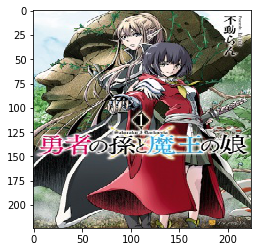

similarity score :  0.5306141


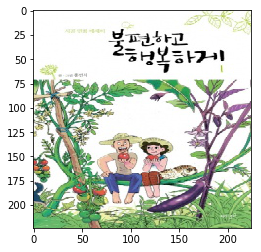

similarity score :  0.52825725
Most similar to OnePunch-Man
-----------------------------------------------------------------------
original manga:


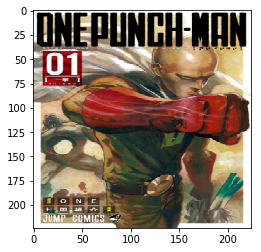

-----------------------------------------------------------------------
most similar manga:


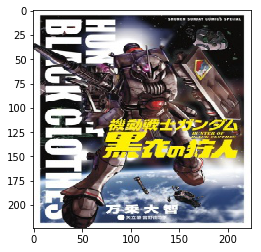

similarity score :  0.6289657


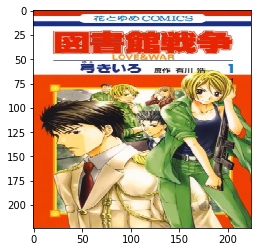

similarity score :  0.61655736


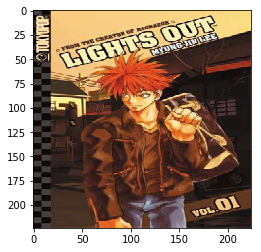

similarity score :  0.6140047


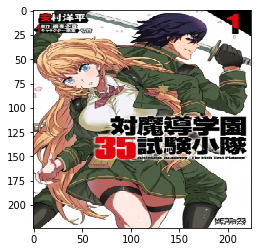

similarity score :  0.61308324


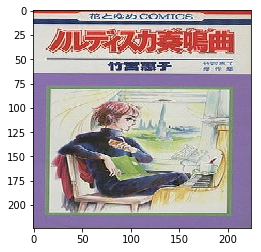


  0%|          | 51/26109 [00:00<00:51, 504.09it/s]

similarity score :  0.60993797
Next model ...


 /t pretrained model <keras.engine.training.Model object at 0x7f8fc80da898> are running



100%|██████████| 26109/26109 [00:58<00:00, 444.89it/s]

============ algorithm predict featurs =========
Our image has 106942464 features:
Most similar to Naruto
-----------------------------------------------------------------------
original manga:


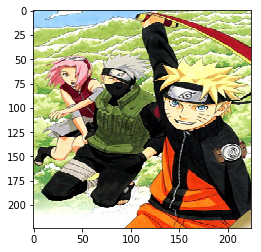

-----------------------------------------------------------------------
most similar manga:


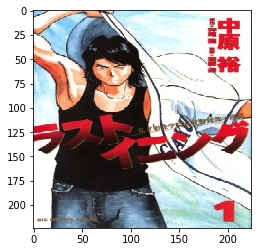

similarity score :  0.59941643


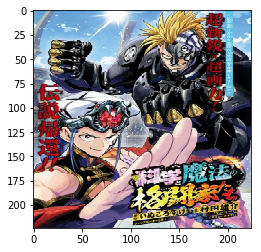

similarity score :  0.59170955


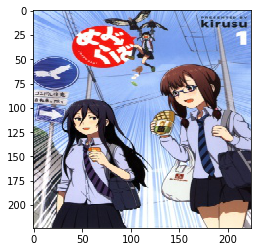

similarity score :  0.5804054


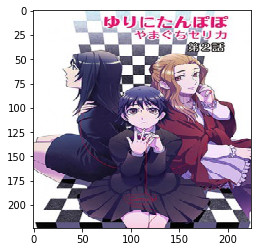

similarity score :  0.57542336


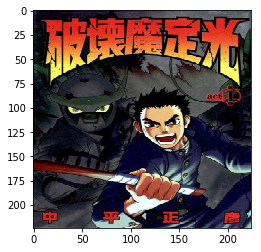

similarity score :  0.5738697
Most similar to OnePunch-Man
-----------------------------------------------------------------------
original manga:


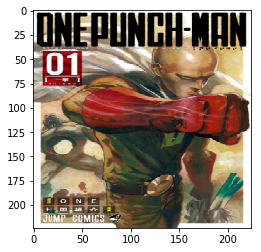

-----------------------------------------------------------------------
most similar manga:


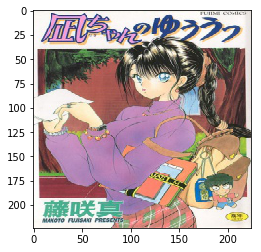

similarity score :  0.6355453


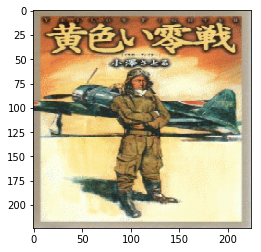

similarity score :  0.62535185


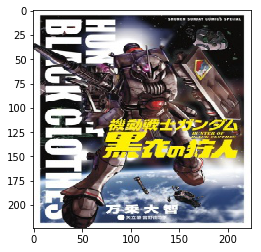

similarity score :  0.62187564


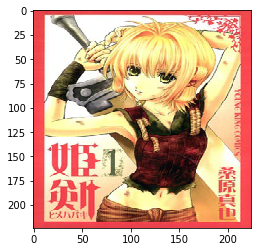

similarity score :  0.6218022


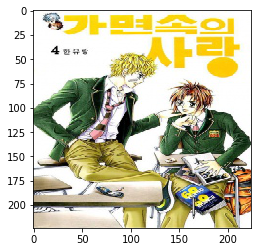


  0%|          | 51/26109 [00:00<00:51, 502.86it/s]

similarity score :  0.61677855
Next model ...


 /t pretrained model <keras.engine.training.Model object at 0x7f8ef71564a8> are running



100%|██████████| 26109/26109 [00:59<00:00, 441.07it/s]

============ algorithm predict featurs =========


E0930 15:21:51.429632 140256541677312 ultratb.py:155] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-aefb09726bc6>", line 13, in <module>
    pretrained_recommender = ImageRecommender(pretrained_model, files, filespath = 'Untitled Folder/')
  File "<ipython-input-15-8e861dea91ba>", line 14, in __init__
    self.sim_table = self.GetSimilarity(self.processed_image)
  File "<ipython-input-15-8e861dea91ba>", line 58, in GetSimilarity
    imgs_features = self.image_features_extractor.predict(processed_imgs)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/training.py", line 1169, in predict
    steps=steps)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/training_arrays.py", line 294, in predict_loop
    batch_outs = f(ins_batch)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 2715, in __call__
    return self

KeyboardInterrupt: 

In [16]:
%matplotlib inline 
from tqdm import tqdm

list_of_pretrained = [mobv2, 
                      nasnetmobile,
                      mobilenet_, 
                      incepv2,
                      incepv3,
                      Xception_, 
                      vgg_model]

for pretrained_model in list_of_pretrained : 
    print('=========================================')
    print(' /t pretrained model %s are running' %pretrained_model)
    print('=========================================')
    pretrained_recommender = ImageRecommender(pretrained_model, files, filespath = 'Untitled Folder/')
    naruto_index, onepunch_index = files.index('Naruto.jpg'), files.index('One_Punch-Man.jpg')
    print('Most similar to Naruto')
    pretrained_recommender.most_similar_to(files[naruto_index])
    print('Most similar to OnePunch-Man')
    pretrained_recommender.most_similar_to(files[onepunch_index])
    print('=========================================')
    pretrained_recommender.most_similar_to(files[777])
    print('=========================================')
    pretrained_recommender.most_similar_to(files[23])
    print('Next model ...')
    print('\n')